In [13]:
import torch
from torchvision import transforms as T
from lightly.transforms import SimCLRTransform, DINOTransform, MAETransform, MoCoV2Transform, utils
from datasets import create_dataset
from models import DINOModel, ClassifierModel
import pytorch_lightning as pl
import os
import copy
import gc
import matplotlib.pyplot as plt

# Losowość

In [2]:
SEED = 42

def seed_everything(seed: int=42):
    pl.seed_everything(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    ####### Normaly you would also need to seed those generators but `pytorch_lightning` does it in one func
    # random.seed(seed)
    # np.random.seed(seed)
    # torch.manual_seed(seed)
    ######
    torch.cuda.manual_seed(seed) # Don't know if pytorch lightning does this
    torch.cuda.manual_seed_all(seed) # Don't know if pytorch lightning does this
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(SEED)

Seed set to 42


# Transformacje (test i scratch różnią sie co najwyżej rozmiarami w zaleznosci od dataseta)

In [3]:
test_transform = T.v2.Compose(
    [
        T.Resize((224, 224)),
        T.v2.ToImage(),
        T.v2.ToDtype(torch.float32, scale=True),
        T.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        )
    ]
)
scratch_transform = T.v2.Compose(
    [
        T.RandomResizedCrop((224, 224)),
        T.RandomHorizontalFlip(),
        T.v2.ToImage(),
        T.v2.ToDtype(torch.float32, scale=True),
        T.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        )
    ]
)

dino_transform = DINOTransform(global_crop_size=224, local_crop_size=112,  # dopasowanie do mniejszych obrazków
                               global_crop_scale=(0.5, 1.0), local_crop_scale=(0.2, 0.5))

/home/hussein/pytoniec/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Datasety

In [4]:
train_full_cifar100_DINO, train_ssl_cifar100_DINO, train_cifar100_DINO, test_cifar100_DINO = create_dataset("CIFAR100", 0.9, dino_transform, scratch_transform, test_transform, "data", False)

Length of entire train dataset:  50000
Length of SSL train dataset:  45000
Length of classification train dataset:  5000
Length of test dataset:  10000


# Hiperparametry uczenia i czyszczenie pamięci

In [5]:
### PARAMETERS ###
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
NUM_WORKERS = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
#GARBAGE COLLECTOR FAJNA SPRAWA - BEZ NIEGO VRAMu BRAKUJE
if device == "gpu":
    torch.cuda.empty_cache()
    gc.collect()

Using device: cuda


# Dataloadery i trening

In [6]:
dl_train_cifar100_DINO = torch.utils.data.DataLoader(
    train_ssl_cifar100_DINO,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)
dl_val_cifar100_DINO = torch.utils.data.DataLoader(
    test_cifar100_DINO,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

#brak argumentu backbone_type - domyślnie używany jest wyuczony resnet18
dino_model = DINOModel(lr=LEARNING_RATE, max_epochs=NUM_EPOCHS)

trainer = pl.Trainer(accelerator='cuda', devices=1, max_epochs=NUM_EPOCHS, precision="16-mixed", log_every_n_steps=1)

trainer.fit(dino_model, dl_train_cifar100_DINO, dl_val_cifar100_DINO)

/home/hussein/pytoniec/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hussein/pytoniec/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hussein/pytoniec/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


# historia uczenia mi się zapisuje do folderów w lightning_logs o generycznych nazwach wypada śledzić, który numer odpowiada któremu modelowi, ewentualnie nie obchodzą nas metryki przy uczeniu

# scory coś się zwaliły ale loss w logach sprawdzić można spada

Text(0, 0.5, 'score')

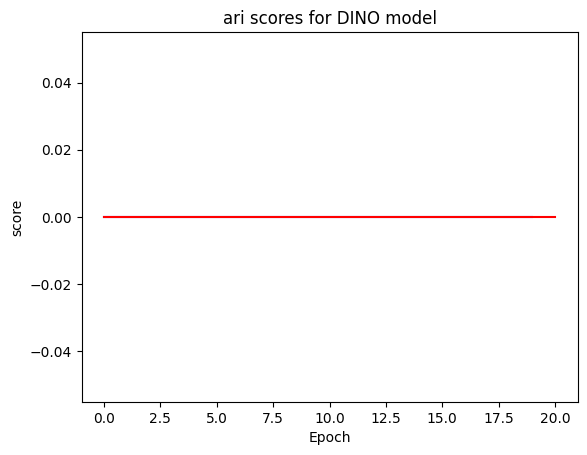

In [9]:
plt.plot(dino_model.train_ari_scores, color = "blue", label = "train_loss")
plt.plot(dino_model.val_ari_scores, color = "red", label = "val_loss")
plt.title('ari scores for DINO model')
plt.xlabel('Epoch')
plt.ylabel('score')

Text(0, 0.5, 'score')

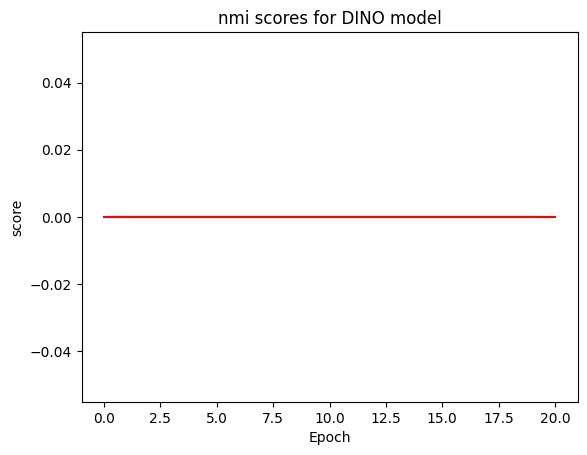

In [10]:
plt.plot(dino_model.train_nmi_scores, color = "blue", label = "train_loss")
plt.plot(dino_model.val_nmi_scores, color = "red", label = "val_loss")
plt.title('nmi scores for DINO model')
plt.xlabel('Epoch')
plt.ylabel('score')

# Linear probing

In [18]:
### PARAMETERS ###
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_WORKERS = 3
NUMBER_OF_CLASSES = 100
device = "cuda"
print(f"Using device: {device}")

Using device: cuda


In [19]:
dl_train = torch.utils.data.DataLoader(
    train_cifar100_DINO,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
dl_eval = torch.utils.data.DataLoader(
    test_cifar100_DINO,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

dino_model_backbone = dino_model.student_backbone
model = copy.deepcopy(dino_model_backbone)

#linear probing
for param in model.parameters():
    param.requires_grad = False

#tyle jest dla resneta na prostej MLP będzie tyle ile dla niej ustawisz
BACKBONE_OUTPUT_DIM = 512

model = torch.nn.Sequential(
    model,
    torch.nn.Flatten(),
    torch.nn.Linear(BACKBONE_OUTPUT_DIM, NUMBER_OF_CLASSES)
)

# Prepare the model
model = ClassifierModel(model=model, num_classes=NUMBER_OF_CLASSES,  lr=LEARNING_RATE, max_epochs=NUM_EPOCHS)

# Prepare the trainer for pytorch lightning
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, devices=-1, accelerator=device)

# Train the model
trainer.fit(model, dl_train, dl_eval)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | Sequential         | 11.2 M | train
1 | criterion    | CrossEntropyLoss   | 0      | train
2 | train_metric | MulticlassAccuracy | 0      | train
3 | val_metric   | MulticlassAccuracy | 0      | train
4 | test_metric  | MulticlassAccuracy | 0      | train
------------------------------------------------------------
51.3 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.911    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


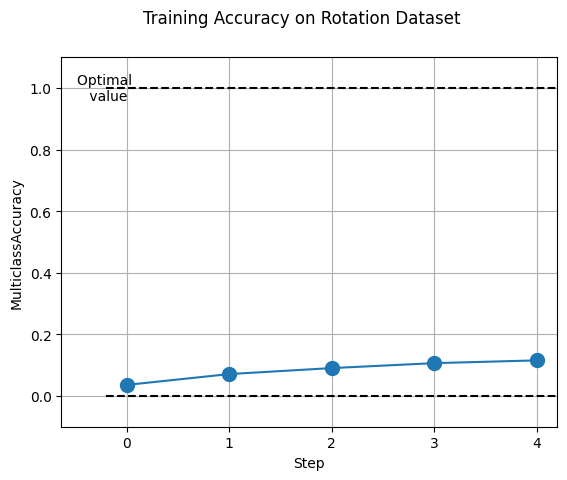

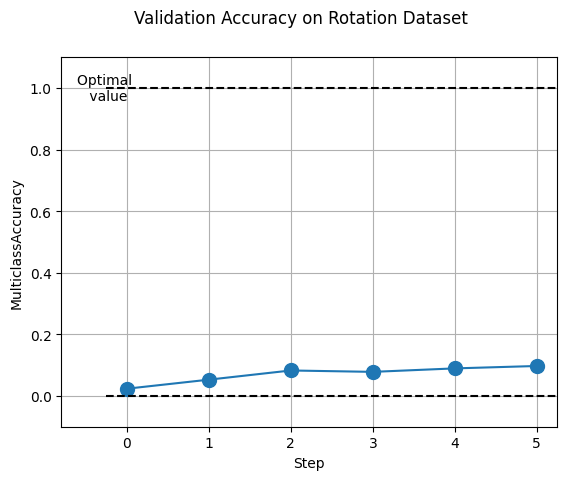

In [20]:
fig, ax = model.train_metric.plot(model.train_acc)
fig.suptitle('Training Accuracy on Rotation Dataset')
fig, ax = model.val_metric.plot(model.val_acc)
fig.suptitle('Validation Accuracy on Rotation Dataset')
plt.show()

## Fine Tuning

In [21]:
dino_model_backbone = dino_model.student_backbone
model = copy.deepcopy(dino_model_backbone)



#tyle jest dla resneta na prostej MLP będzie tyle ile dla niej ustawisz
BACKBONE_OUTPUT_DIM = 512

model = torch.nn.Sequential(
    model,
    torch.nn.Flatten(),
    torch.nn.Linear(BACKBONE_OUTPUT_DIM, NUMBER_OF_CLASSES)
)

# Prepare the model
model = ClassifierModel(model=model, num_classes=NUMBER_OF_CLASSES,  lr=LEARNING_RATE, max_epochs=NUM_EPOCHS)

# Prepare the trainer for pytorch lightning
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, devices=-1, accelerator=device)

# Train the model
trainer.fit(model, dl_train, dl_eval)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | Sequential         | 11.2 M | train
1 | criterion    | CrossEntropyLoss   | 0      | train
2 | train_metric | MulticlassAccuracy | 0      | train
3 | val_metric   | MulticlassAccuracy | 0      | train
4 | test_metric  | MulticlassAccuracy | 0      | train
------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.911    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/hussein/pytoniec/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


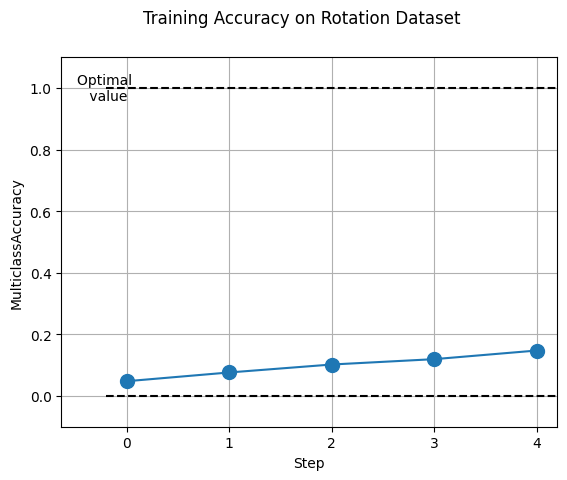

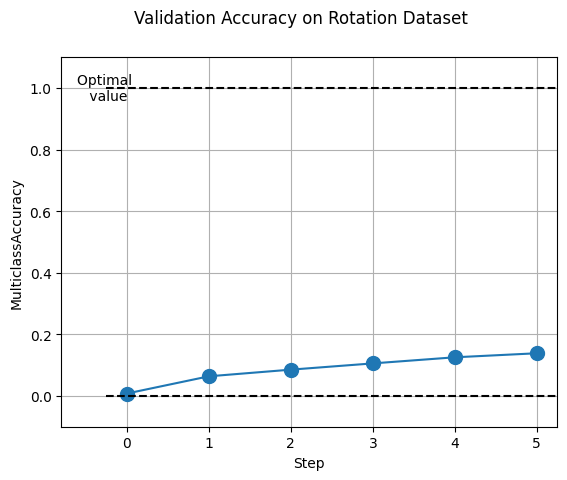

In [22]:
fig, ax = model.train_metric.plot(model.train_acc)
fig.suptitle('Training Accuracy on Rotation Dataset')
fig, ax = model.val_metric.plot(model.val_acc)
fig.suptitle('Validation Accuracy on Rotation Dataset')
plt.show()